# Part 1
Generate a word cloud based on the raw corpus I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud). With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and cons (if any) of the two word clouds you generated

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nl
from nltk.corpus import stopwords as nlstopw
import re
import string


%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns
plt.rcParams['figure.figsize'] = (20, 15)

Some functions to create and plot the wordclouds

In [2]:
def plot_word_cloud(wordcloud):
    plt.imshow(wordcloud)
    plt.axis("off")

In [3]:
def plot_wordclouds(clouds, titles):
    r = len(clouds) // 2 + 1
    for i in range(0, len(clouds)):
        plt.subplot(r, 2, i+1)
        plt.title(titles[i])
        plt.imshow(clouds[i])
        plt.axis("off")

In [4]:
def make_wordcloud(s, stopwords):
    return WordCloud(stopwords=stopwords, width=600, height=400, prefer_horizontal=0.7, max_words=500, 
                          background_color='black').generate(s)

## Look at the raw emails
We take the _ExtractedBodyText_ and _ExtractedSubject_ fields and not the _RawText_ because the RawText contains a lot of additional words and fields that do not belong into the word cloud. 
_ExtractedBodyText_ and _ExtractedSubject_ have some NaNs, but there is still enough data to work with without them.

In [5]:
# read the raw emails:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', index_col='Id')
raw_text = ' '.join(emails.ExtractedBodyText.dropna().values) + ' '.join(emails.ExtractedSubject.dropna().values)

### Raw Wordcloud
On the raw corpus without stopword removal, _"the"_ is the most used word, followed by _"and"_, _"in"_, _"o"f_, _"to"_ etc. This are all stopwords that don't characterize the input text at all.

Every english text would probably generate the same result.
To show this, we took the raw text of the first book of the _hitchikers guide to the galaxy_ series.
You can see the two wordcloudsbelow. Notice how similar they are.

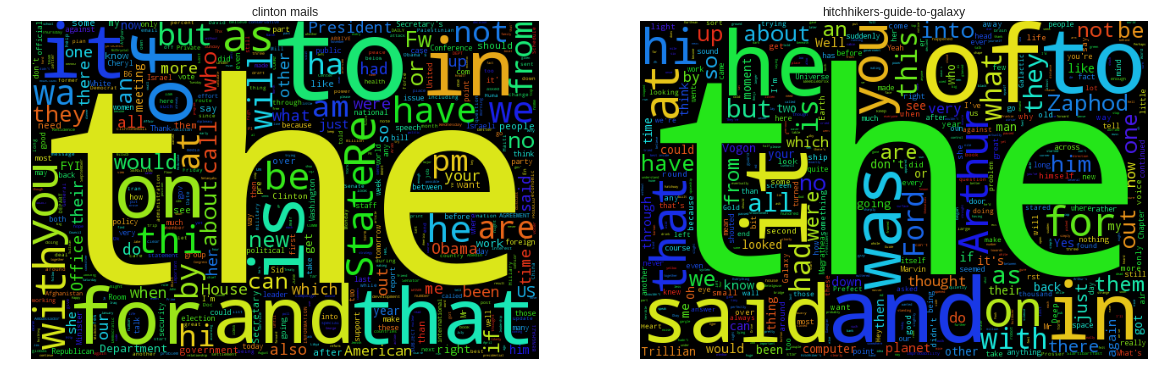

In [6]:
wc_emails = make_wordcloud(raw_text, stopwords=[''])

# source: http://paulyhart.blogspot.ch/2011/10/hitchhikers-guide-to-galaxy-text_28.html
hgttg_text = open('files/hitchikers_guide_to_the_galaxy.txt').read()
wc_hgttg = make_wordcloud(hgttg_text, stopwords=[''])

plot_wordclouds([wc_emails, wc_hgttg], ['clinton mails', 'hitchhikers-guide-to-galaxy'])

The WordCloud module has their own stopwords, lets see what happens when we use them.
For the emails, we also include words like _Re_, _Fw_, _Fvv_, _Fwd_ etc to the Stoplist since these words appear in the email subjects and don't really belong to the text.

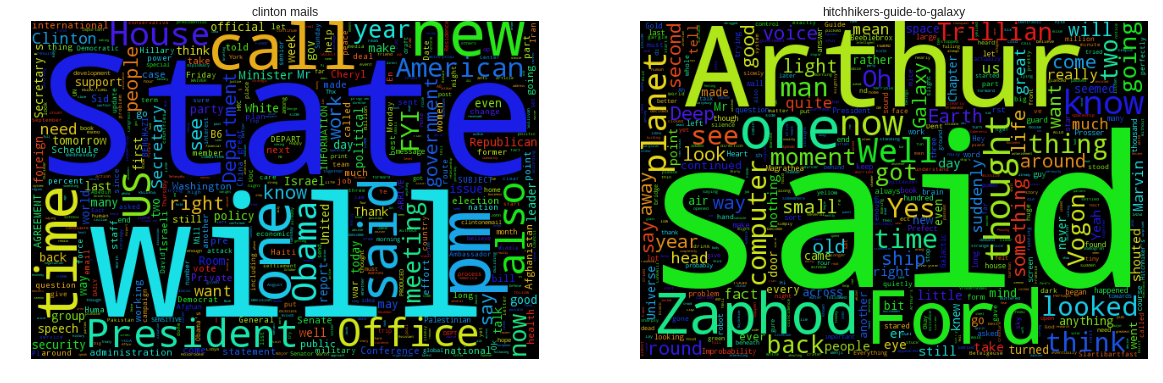

In [7]:
email_stopwords = set(['Re', 'RE', 're', 'Fw', 'FW', 'fw', 'Fvv', 'FVV', 'Fwd', 'FWD', 'fwd']).union(STOPWORDS)
wc_emails_stopw = make_wordcloud(raw_text, stopwords=email_stopwords)
wc_hgttg_stopw = make_wordcloud(hgttg_text, stopwords=STOPWORDS) 

plot_wordclouds([wc_emails_stopw, wc_hgttg_stopw], ['clinton mails', 'hitchhikers-guide-to-galaxy'])

The two word clouds already represent their text much better.

The clinton mails are clearly USA themed (with words like _"US"_, _"President"_, _"Obama"_, _"clinton"_ etc). It is interesting that _"will"_ is the most used word, followed by _"State"_. It seems that the emails speek often about the future. _"call"_, _"pm"_ and _"time"_ are other popular words, maybe implying that the emails are used to arrange phone-calls in the afternoon. _"pm"_ may in addition to _"afternoon"_ also refer to "personal message".

In the hitchhikers cloud, _"Ford"_, _"Zaphod"_, _"Trillian"_ and _"Arthur"_ are the protagonists of the book. _"said"_ is the most used word, which is no surprise for a book telling a story. Other words like _"planet"_, _"Vogon"_ and _"computer"_ are also quite characteristic for that book.

## Text pre-processing
Now lets create the pipeline and use it on the emails:  
cleaning, tokenization, stopword removal, stemming, lemmatization

First we remove punktuation


In [8]:
# remove punktuation
raw_text = re.sub('['+string.punctuation+']', '', raw_text)

Then we tokenize, remove stepwords and use different stemmers and a lemmatizer to compare the output.

In [9]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

# tokenize
nl.download('punkt') # needed for word tokenization
tokens = nl.word_tokenize(raw_text)
print("number of tokens:", len(tokens))

# remove stopwords
tokens = [tok for tok in tokens if tok not in email_stopwords]
print("number of tokens after stepword removing:", len(tokens))

# stem the tokens
stemmer_L = LancasterStemmer()
stemmer_E = EnglishStemmer()

stemmed_L = [stemmer_L.stem(tok) for tok in tokens]
stemmed_E = [stemmer_E.stem(tok) for tok in tokens]

# do a lemmatization
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in tokens]


[nltk_data] Downloading package punkt to /home/lukas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
number of tokens: 627006
number of tokens after stepword removing: 397355


## Comparison
We compare the two stemmers and a lemmatizer to the wordcloud generated only out of the tokens.
The two stemmers are the Lancaster and Snowball (English) stemmer. And the Lemmatizer the WordNetLemmatizer.

- Tokens only is very similar to the raw_text without stepwords.
- Lancaster stems the words more agressive than the Snowball.
- Snowball seems good, and is still very similar to the not stemmed one.
- Lemmatization seems to have almost no effect.

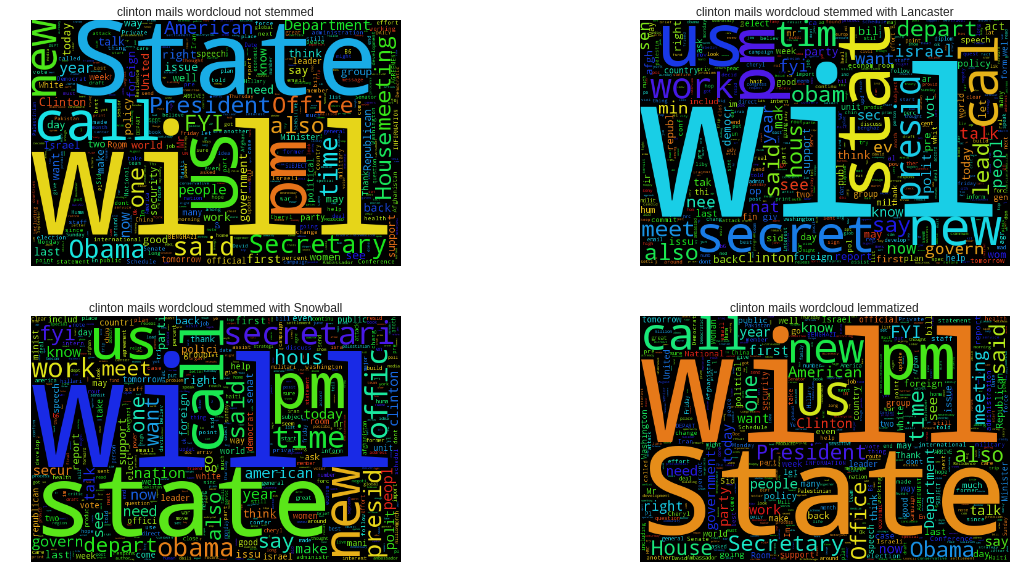

In [10]:
wc_tokens_emails = make_wordcloud(' '.join(tokens), stopwords=email_stopwords)
wc_stemmedL_emails = make_wordcloud(' '.join(stemmed_L), stopwords=email_stopwords)
wc_stemmedE_emails = make_wordcloud(' '.join(stemmed_E), stopwords=email_stopwords)
wc_lemm = make_wordcloud(' '.join(lemmatized), stopwords=email_stopwords)

plot_wordclouds([wc_tokens_emails, wc_stemmedL_emails, wc_stemmedE_emails, wc_lemm], 
                ['clinton mails wordcloud not stemmed', 'clinton mails wordcloud stemmed with Lancaster', 'clinton mails wordcloud stemmed with Snowball', 'clinton mails wordcloud lemmatized'])

Now lets look at the the top 12 words of the 4 wordclouds:

In [11]:
s1 = sorted(wc_tokens_emails.words_, key=lambda x: x[1], reverse=True)
s2 = sorted(wc_stemmedL_emails.words_, key=lambda x: x[1], reverse=True)
s3 = sorted(wc_stemmedE_emails.words_, key=lambda x: x[1], reverse=True)
s4 = sorted(wc_lemm.words_, key=lambda x: x[1], reverse=True)

print("tokens:           ", [t[0] for t in s1][:12])
print("stemmed Lancaster:", [t[0] for t in s2][:12])
print("stemmed Snowball :", [t[0] for t in s3][:12])
print("lemmatized :", [t[0] for t in s4][:12])

tokens:            ['will', 'State', 'pm', 'US', 'call', 'new', 'Secretary', 'time', 'Obama', 'said', 'Office', 'President']
stemmed Lancaster: ['wil', 'stat', 'us', 'pm', 'cal', 'new', 'secret', 'presid', 'tim', 'work', 'depart', 'said']
stemmed Snowball : ['will', 'state', 'pm', 'call', 'us', 'new', 'secretari', 'time', 'offic', 'work', 'obama', 'presid']
lemmatized : ['will', 'State', 'pm', 'call', 'US', 'new', 'Secretary', 'time', 'Obama', 'said', 'Office', 'President']


The frequent words are surprisingly similar. The two stemmers cut some words somewhat agressively (_secretari_ or _offic_). The lemmatization seems to have no big effect compared to the tokenized one, but it seems right to do it.

The following plot shows how few words appear the most, and that they are simiar for all 4 wordclouds. That means neither stemming nor lemmatizations changed the outcome drastically.

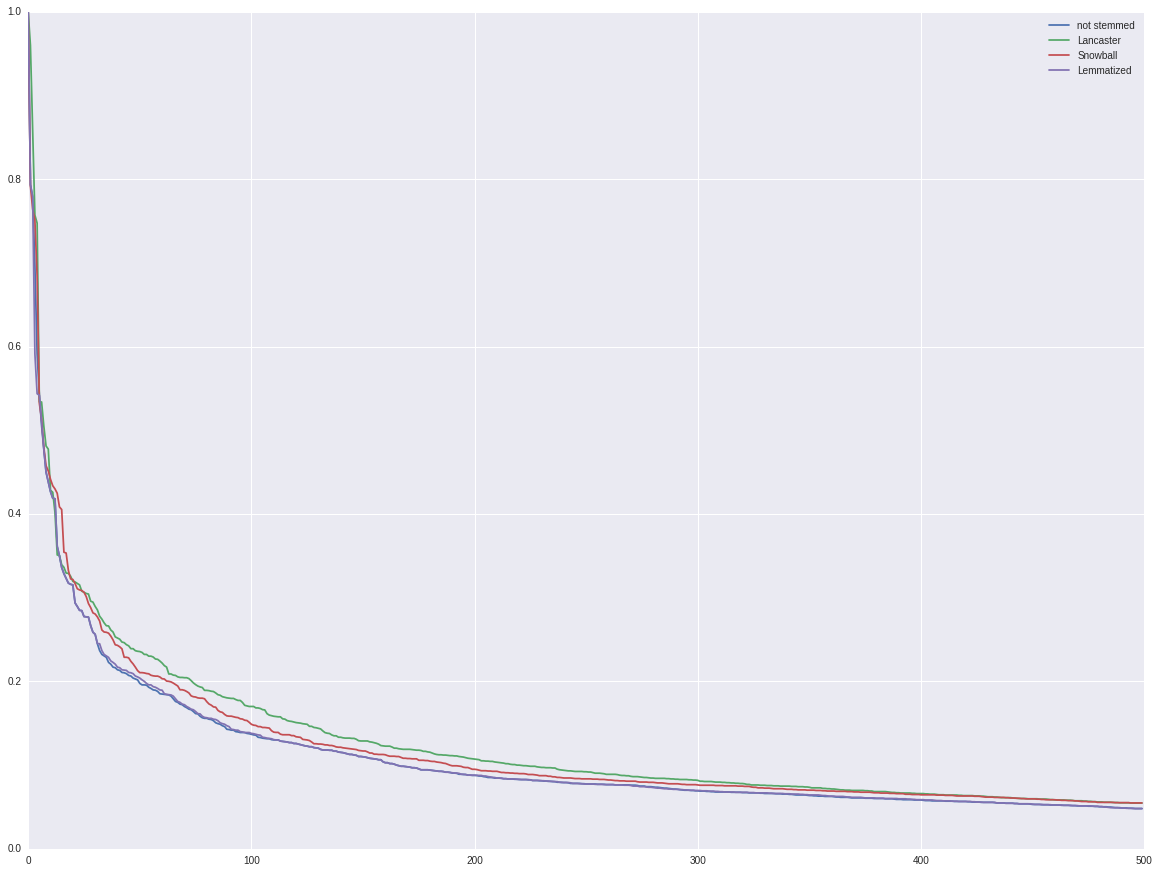

In [12]:
plt.plot([t[1] for t in s1], label='not stemmed')
plt.plot([t[1] for t in s2], label='Lancaster')
plt.plot([t[1] for t in s3], label='Snowball')
plt.plot([t[1] for t in s4], label='Lemmatized')
plt.legend()

Some people may consider _"will"_ a stopword. So here is a wordcloud without _"will"_:


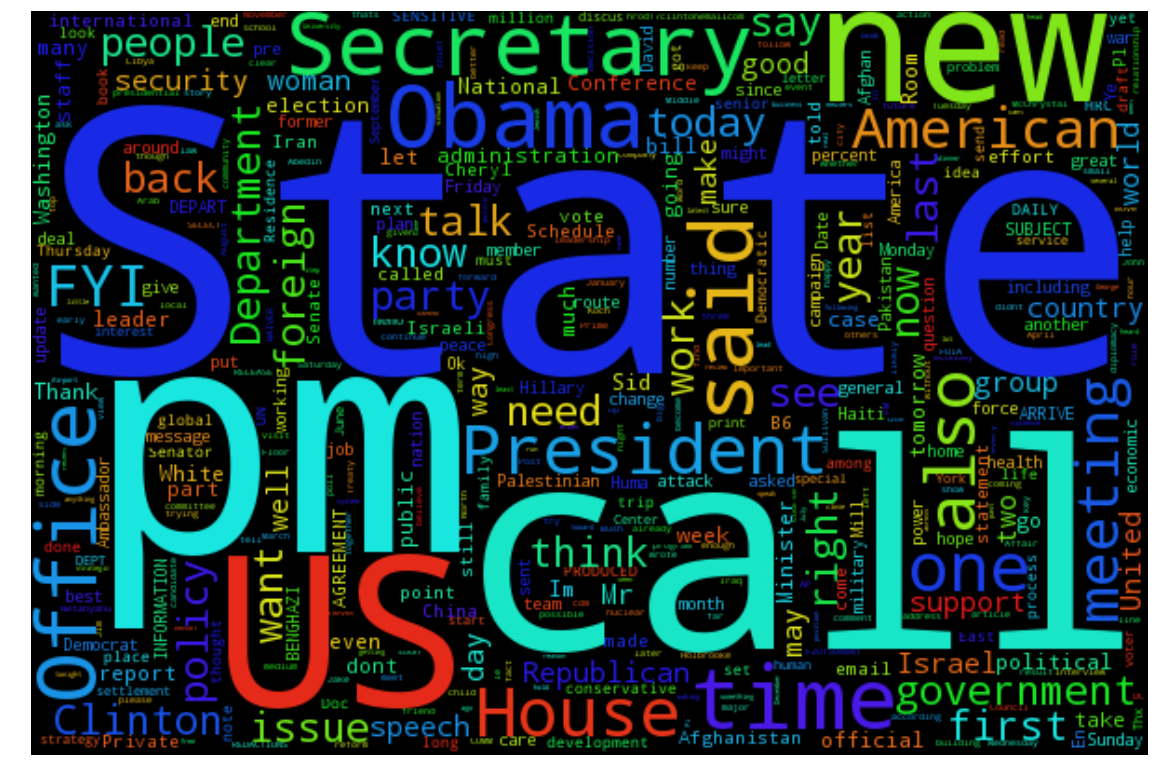

In [13]:
wc_no_will = make_wordcloud(' '.join(lemmatized), email_stopwords.union(set(['will'])))
plot_word_cloud(wc_no_will)